# Vehicle Detection Project
---
 The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

---

## Data reparation

In [80]:
# Include used module and function
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from lesson_functions import *
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    print(data_dict["n_cars"])
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    print(data_dict["n_notcars"])
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    img = cv2.imread(car_list[0])
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict

In [79]:
notcar_path = ['./training_samples/non-vehicles/GTI/*.png',
            './training_samples/non-vehicles/Extras/*.png',]
car_path = ['./training_samples/vehicles/GTI_Far/*.png',
           './training_samples/vehicles/GTI_Left/*.png',
           './training_samples/vehicles/GTI_MiddleClose/*.png',
           './training_samples/vehicles/GTI_Right/*.png',
            './training_samples/vehicles/KITTI_extracted/*.png',]

cars = []
for path in car_path:
    cars.extend(glob.glob(path))

notcars = []
for path in notcar_path:
    notcars.extend(glob.glob(path))

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

8792
8968
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


## Histogram of Oriented Gradients (HOG)
---
### 1\. Explain how (and identify where in your code) you extracted HOG features from the training images.
I select one image from each of the car and non-car data set to demonstrate the difference in HOG features.
Here are the example:

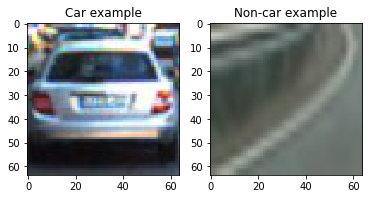

In [49]:
car_image = mpimg.imread('./output_images/40.jpeg')
notcar_image = mpimg.imread('./output_images//image0186.jpeg')

plt.subplot(121)
plt.imshow(car_image)
plt.title('Car example')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Non-car example')

The `get_hog_features()` in `lesson_functions.py` (line 6 through line 23) is parameter wrapper to `skimage.hog()`.

I then explored different color spaces and different `skimage.hog()` parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like. An example displaying hog feature with repect to each channel for the two images is showing below:


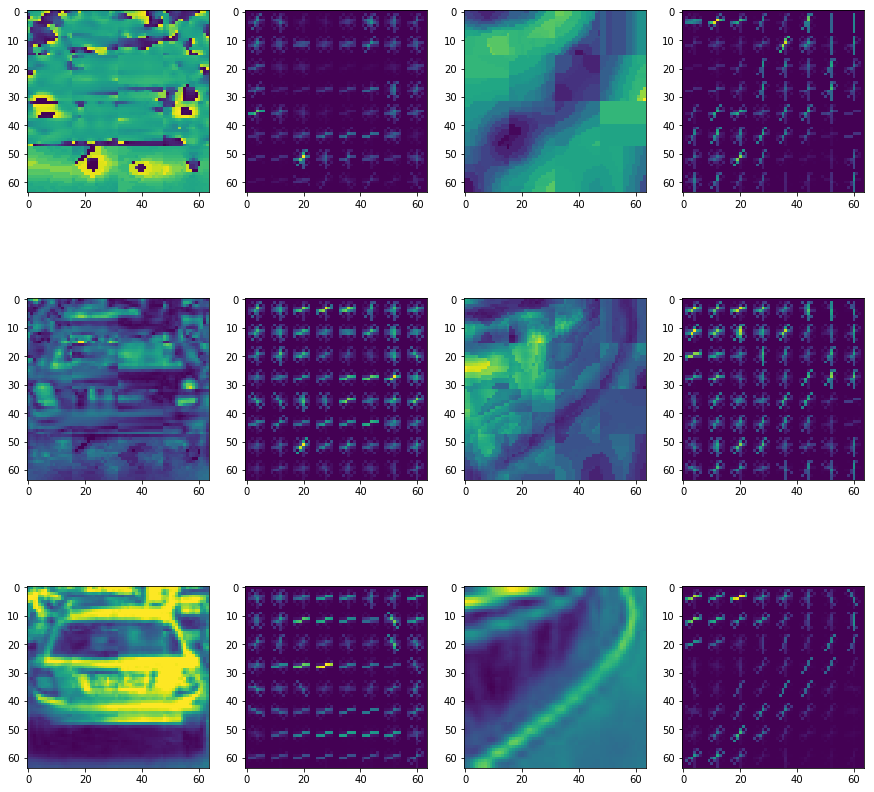

In [47]:
car_cs_img = cv2.cvtColor(car_image, cv2.COLOR_RGB2HSV)
notcar_cs_img = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2HSV)

row,col = 3,4
f, ax = plt.subplots(row, col, figsize=(15,15))
for r in range(row):
    plt.subplot(row, col, 1 + r * col)
    plt.imshow(car_cs_img[:,:,r])
    
    plt.subplot(row, col, 2 + r * col)
    features,vis_img = get_hog_features(car_cs_img[:,:,r], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    plt.imshow(vis_img)
    
    plt.subplot(row, col, 3 + r * col)
    plt.imshow(notcar_cs_img[:,:,r])
    
    plt.subplot(row, col, 4 + r * col)
    features,vis_img = get_hog_features(notcar_cs_img[:,:,r], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    plt.imshow(vis_img)

### 2\. Explain how you settled on your final choice of HOG parameters.
I tried various combinations of parameters. Consider the example using HSV and HLS color spaces above, it is obvious that the lightness channel is better for object shape detection. The HOG features are apparent for the two images.
### 3\. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

In [ ]:
cspace='HSV'
spatial = 32
histbin = 64

orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'

car_features = extract_features(cars, color_space=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features = extract_features(notcars, color_space=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

from sklearn.preprocessing import StandardScaler
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')